In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# transforming data to tensor
tensor_transform = transforms.ToTensor()

# initializing datasets from FashionMNIST
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tensor_transform)

# creating data loaders to load data during training and testing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

In [2]:
# basic autoencoder model, latent represenation size is 10
class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # encoder part
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
            torch.nn.ReLU(),
        )
        # decoder part
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        # flattening the input image
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # reshaping back to original dimensions
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

In [3]:
# initializing model, loss function and optimizer
model = AE()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [4]:
# passing the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [5]:
# training the model
epochs = 20
losses = []
for epoch in range(epochs):
    for image, _ in train_loader:
        image = image.to(device)
        reconstructed = model(image)
        loss = loss_function(reconstructed, image)
        losses.append(loss.cpu().data.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}/{epochs-1}")
    print(f"loss: {loss}")

Epoch 0/19
loss: 0.021670902147889137
Epoch 1/19
loss: 0.023119905963540077
Epoch 2/19
loss: 0.02061251737177372
Epoch 3/19
loss: 0.016592271625995636
Epoch 4/19
loss: 0.015873711556196213
Epoch 5/19
loss: 0.01597422920167446
Epoch 6/19
loss: 0.016098380088806152
Epoch 7/19
loss: 0.016015561297535896
Epoch 8/19
loss: 0.016448864713311195
Epoch 9/19
loss: 0.0137044508010149
Epoch 10/19
loss: 0.01478520780801773
Epoch 11/19
loss: 0.014354581013321877
Epoch 12/19
loss: 0.017679745331406593
Epoch 13/19
loss: 0.010880609042942524
Epoch 14/19
loss: 0.018506255000829697
Epoch 15/19
loss: 0.017157699912786484
Epoch 16/19
loss: 0.014333785511553288
Epoch 17/19
loss: 0.013962247408926487
Epoch 18/19
loss: 0.01609688811004162
Epoch 19/19
loss: 0.015709267929196358


In [6]:
PATH = "./autoencoder.pth"
torch.save(model.state_dict(), PATH)

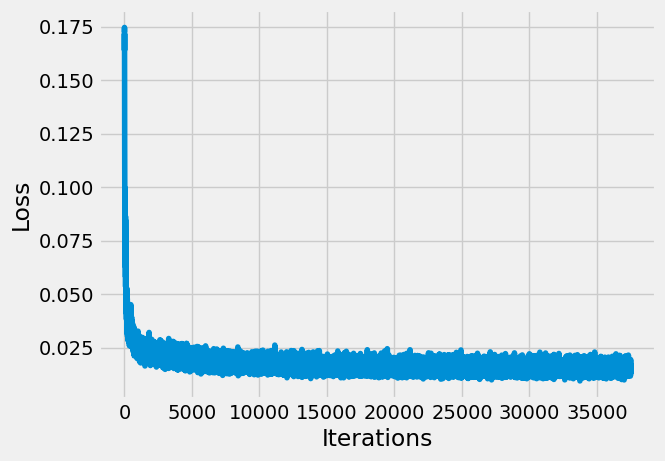

In [7]:
# plot of the loss value over all iterations
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(losses[:])

In [8]:
model = AE()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.to(device)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
# evaluating the autoencoder with test data
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
with torch.no_grad():
    output = model(images)

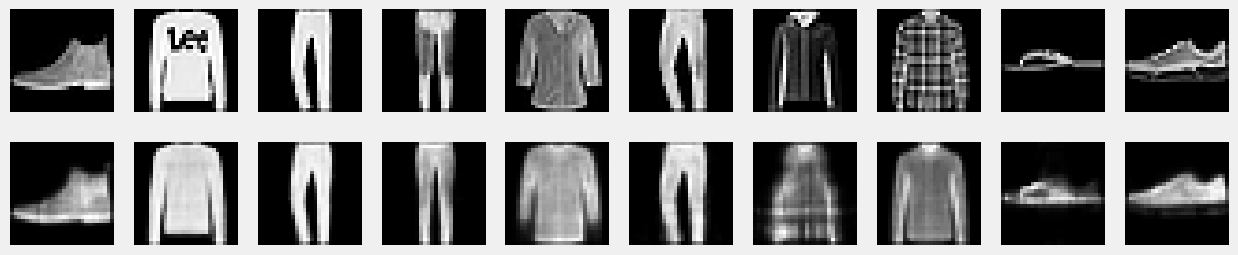

In [10]:
# plot of evaluation results
fig, axes = plt.subplots(2, 10, figsize=(14, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(output[i].cpu().detach().numpy().squeeze(), cmap="gray")
    axes[1, i].axis("off")
plt.show()